In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos import *

In [2]:
import sys
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Set random seed
np.random.seed(2027)

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 2.7.14+ (default, Apr 19 2019, 15:48:06) [GCC 7.4.1 20190129]
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Settings

zone = 0

#nevents = 200000
nevents = -1

# Input files
signal = 'signal_add.1.npz'
bkgnd = 'bkgnd_add.1.npz'

# Image format
num_channels = 3
num_cols = 300
num_rows = 10
image_format = (num_rows, num_cols, num_channels)

# Parameter
num_pars = 5

# q/pT and d0 binning
#invpt_bins = np.array([-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
#dzero_bins = np.array([-150., -90., -30., 30., 90., 150.])

# Customise
if zone == 0:
  pref_row = 4
  invpt_bins = np.array([-0.49277655, -0.24515343, -0.06501561, 0.06501561, 0.24515343, 0.49277655])
  dzero_bins = np.array([-149.01635796, -80.24550629, -19.69444885, 19.69444885, 80.24550629, 149.01635796])
elif zone == 1:
  pref_row = 5
  invpt_bins = np.array([-0.49370697, -0.26011642, -0.07240327, 0.07240327, 0.26011642, 0.49370697])
  dzero_bins = np.array([-148.42751366, -75.90176582, -18.08490837, 18.08490837, 75.90176582, 148.42751366])
elif zone == 2:
  pref_row = 3
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
elif zone == 3:
  pref_row = 6
  invpt_bins = np.array([-0.4293814, -0.20216908, -0.06793304, 0.06793304, 0.20216908, 0.4293814])
  dzero_bins = np.array([-148.45433655, -73.98971748, -17.79024315, 17.79024315, 73.98971748, 148.45433655])
else:
  raise RuntimeError('Cannot recognize zone: {0}'.format(zone))

# Labels
zone_row_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1', 'none' ],
  ['GE1/1', 'ME1/1', 'ME1/2', 'RE1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2', 'none' , 'none' ],
  ['MB1'  , 'MB2'  , 'MB3'  , 'ME1/3', 'RE1/3', 'RE2/3', 'ME2/2', 'ME3/2', 'RE3/3', 'ME4/2'],
]

logger.info('Processing zone {0}'.format(zone))
logger.info('.. nevents      : {0}'.format(nevents))
logger.info('.. image_format : {0}'.format(image_format))
logger.info('.. pref_row     : {0}'.format(pref_row))
logger.info('.. invpt_bins   : {0}'.format(invpt_bins))
logger.info('.. dzero_bins   : {0}'.format(dzero_bins))

[INFO    ] Processing zone 0
[INFO    ] .. nevents      : -1
[INFO    ] .. image_format : (10, 300, 3)
[INFO    ] .. pref_row     : 4
[INFO    ] .. invpt_bins   : [-0.49277655 -0.24515343 -0.06501561  0.06501561  0.24515343  0.49277655]
[INFO    ] .. dzero_bins   : [-149.01635796  -80.24550629  -19.69444885   19.69444885   80.24550629
  149.01635796]


In [4]:
# Binning functions

def my_digitize(x, bins):
  # first and last bins include underflow and overflow
  ind = np.searchsorted(bins, x)
  ind = np.clip(ind-1, 0, len(bins)-2)  # starts from 0
  return ind

def find_par_row_col(par):
  if par.ndim == 1:
    (invpt, d0, eta, phi, invpt2) = par
  else:
    (invpt, d0, eta, phi, invpt2) = np.split(par, np.array([1,2,3,4]), axis=1)
  ind0 = my_digitize(invpt2, invpt_bins)
  ind1 = my_digitize(d0, dzero_bins)
  return (ind1, ind0)

In [5]:
# Plotting functions

# matplotlib hist2d takes the (x, y) arrays as input, do the binning and plot.
# this hist2d takes a single, already-binned-in-2d, array as input, and plot.
#
# based on root2matplotlib from rootpy:
#     http://www.rootpy.org/_modules/rootpy/plotting/root2matplotlib.html#hist2d
#
def hist2d_on_binned_array(hist, xedges, yedges, ax=None, cmap=None, vmin=None, vmax=None, colorbar=False):
  if ax is None:
    ax = plt.gca()
  xdata = (xedges[1:] + xedges[:-1])/2
  ydata = (yedges[1:] + yedges[:-1])/2
  xv, yv = np.meshgrid(xdata, ydata)
  x = xv.ravel()
  y = yv.ravel()
  z = hist.T.ravel()
  h, xedges, yedges, im = ax.hist2d(x, y, weights=z, bins=(xedges, yedges), cmap=cmap, vmin=vmin, vmax=vmax)
  if colorbar:
    cb = ax.figure.colorbar(im, ax=ax)
  return h, xedges, yedges, im

# same thing for 1d
def hist_on_binned_array(hist, edges, ax=None):
  if ax is None:
    ax = plt.gca()
  x = (edges[1:] + edges[:-1])/2
  h, edges, patches = ax.hist(x, weights=hist, bins=edges)
  return h, edges, patches

### Load data

In [6]:
import h5py

f_hdf5 = None  # file handle

annotations_filename = ('annotations_zone%i.1.h5' % zone)

def load_annotations(filename):
  logger.info('Loading from {0}'.format(filename))

  global f_hdf5
  f_hdf5 = h5py.File(filename, 'r')
  
  images_x = f_hdf5['images_x']
  images_y = f_hdf5['images_y']
  images_c = f_hdf5['images_c']
  logger.info('images_x: {0} images_y: {1} images_c: {2}'.format(images_x.shape, images_y.shape, images_c.shape))
  return (images_x, images_y, images_c)

In [7]:
(images_x, images_y, images_c) = load_annotations(annotations_filename)

[INFO    ] Loading from annotations_zone0.1.h5
[INFO    ] images_x: (500000, 10, 99, 1) images_y: (500000, 25) images_c: (500000, 1)


In [8]:
# Split into training and test data
from sklearn.model_selection import train_test_split

test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(images_x[:].astype(np.float32), images_y[:].astype(np.float32), test_size=test_size, shuffle=False)
logger.info('x_train: {0} x_test: {1} y_train: {2} y_test: {3}'.format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))

[INFO    ] x_train: (400000, 10, 99, 1) x_test: (100000, 10, 99, 1) y_train: (400000, 25) y_test: (100000, 25)


In [9]:
# Parameters from 'boxes'
num_box_rows = num_rows

num_box_cols = 99

num_box_channels = 1

box_col_offset = 49

num_par_rows = len(invpt_bins)-1

num_par_cols = len(dzero_bins)-1

# Parameters from 'annotations'
num_annot_rows = num_par_rows * num_par_cols

num_annot_cols = num_cols

num_annot_labels = num_annot_rows

num_annot_extra_labels = 1  # (pref_cols,)

### Create model

In [10]:
# Imports

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras import backend as K

In [11]:
# Loss functions

def weighted_crossentropy(target, output, pos_weight=1, from_logits=False):
  # Note: tf.nn.sigmoid_cross_entropy_with_logits
  # expects logits, Keras expects probabilities.
  if not from_logits:
    # transform back to logits
    _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.log(output / (1 - output))
  return tf.nn.weighted_cross_entropy_with_logits(targets=target, logits=output, pos_weight=pos_weight)

In [12]:
input_shape = (num_box_rows, num_box_cols, 1)
num_classes = num_annot_labels

learning_rate = 0.001
epochs = 80
batch_size = 1024

#model = Sequential()
#model.add(Conv2D(25, kernel_size=(10, 10), activation='relu',
#                 input_shape=input_shape))
#model.add(Conv2D(25, kernel_size=(1, 10), activation='relu'))
#model.add(Conv2D(25, kernel_size=(1, 10), activation='relu'))
#model.add(Conv2D(25, kernel_size=(1, 10), activation='relu'))
#model.add(Flatten())
#model.add(Dense(25, activation='relu'))
#model.add(Dense(num_classes, activation='softmax'))

model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(100, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=keras.regularizers.l2(0.0001)))
#model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss=weighted_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 990)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               99100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
Total params: 105,425
Trainable params: 105,425
Non-trainable params: 0
_________________________________________________________________


### Training

In [13]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
                    validation_data=(x_test, y_test))

Train on 400000 samples, validate on 100000 samples
Epoch 1/80
400000/400000 [==============================] - 3s 9us/step - loss: 0.2036 - acc: 0.1507 - val_loss: 0.1387 - val_acc: 0.2067
Epoch 2/80
400000/400000 [==============================] - 3s 8us/step - loss: 0.1334 - acc: 0.2309 - val_loss: 0.1323 - val_acc: 0.2367
Epoch 3/80
400000/400000 [==============================] - 4s 11us/step - loss: 0.1288 - acc: 0.2556 - val_loss: 0.1292 - val_acc: 0.2552
Epoch 4/80
400000/400000 [==============================] - 3s 8us/step - loss: 0.1260 - acc: 0.2720 - val_loss: 0.1268 - val_acc: 0.2671
Epoch 5/80
400000/400000 [==============================] - 3s 7us/step - loss: 0.1237 - acc: 0.2852 - val_loss: 0.1247 - val_acc: 0.2791
Epoch 6/80
400000/400000 [==============================] - 4s 9us/step - loss: 0.1218 - acc: 0.2957 - val_loss: 0.1232 - val_acc: 0.2850
Epoch 7/80
400000/400000 [==============================] - 3s 7us/step - loss: 0.1203 - acc: 0.3031 - val_loss: 0.1218

In [14]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(plt.cm.viridis.colors, name='viridis_mod')
my_cmap.set_under('w',1)

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


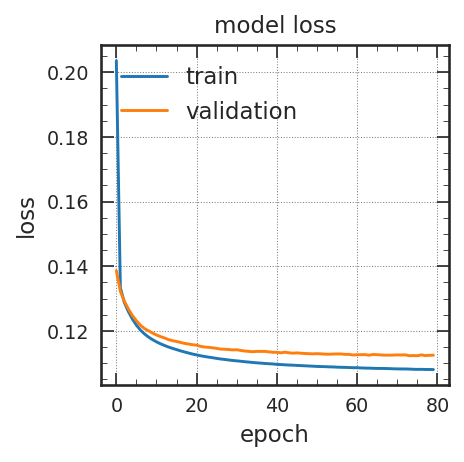

In [15]:
# Plot loss vs epoch
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
#ax.set_ylim(2,8)
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluate

In [16]:
loaded_model = model

y_test_pred = loaded_model.predict(x_test, batch_size=4096)
print(y_test.shape, y_test_pred.shape)

(100000, 25) (100000, 25)


0


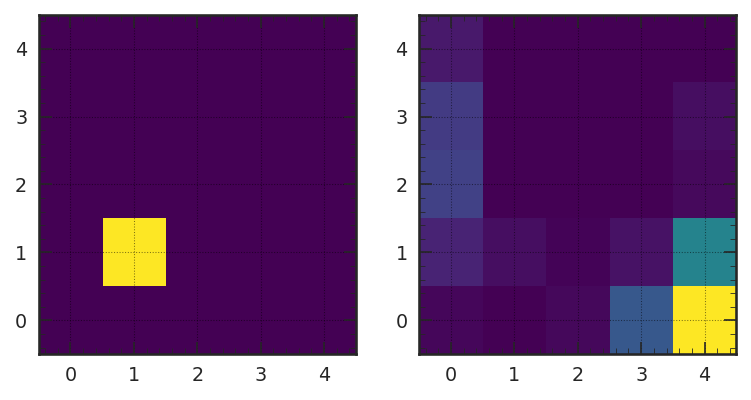

1


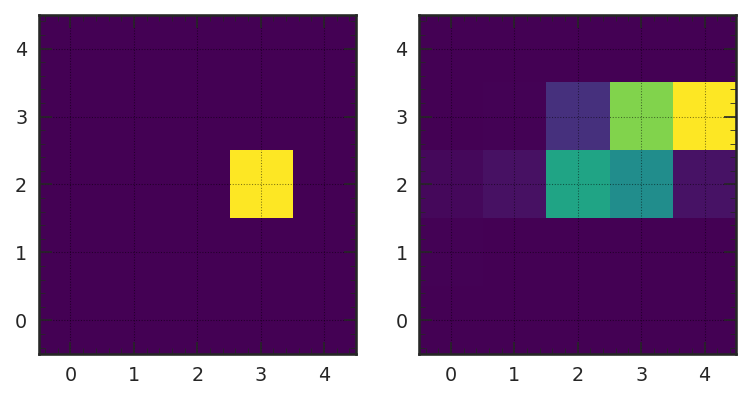

2


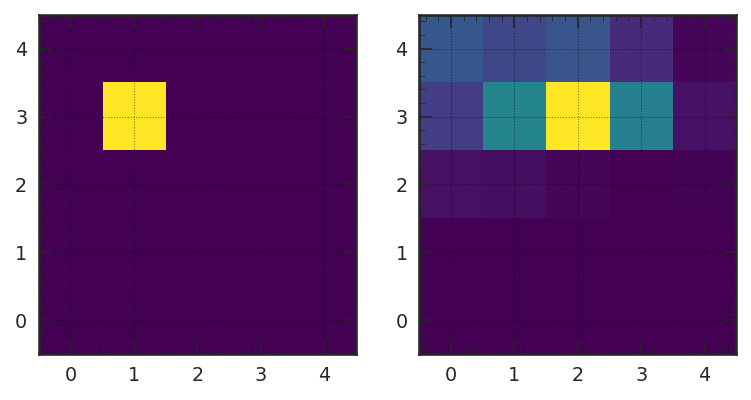

3


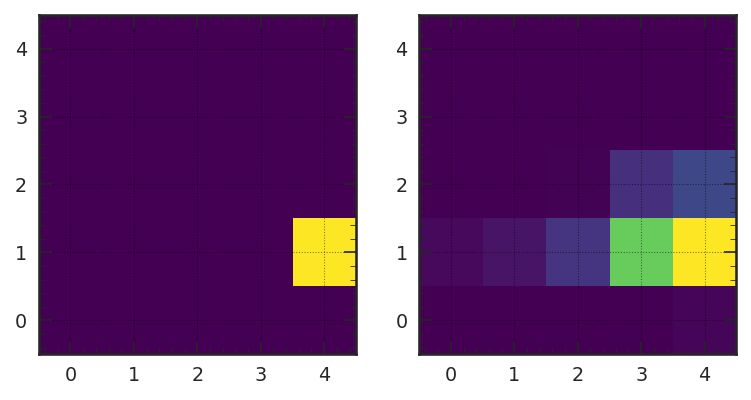

4


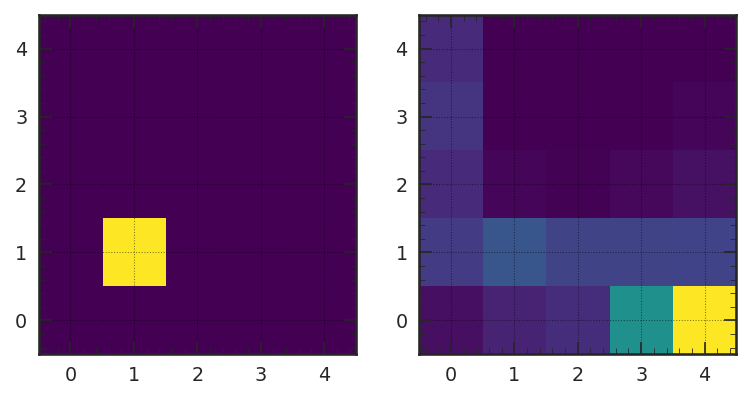

5


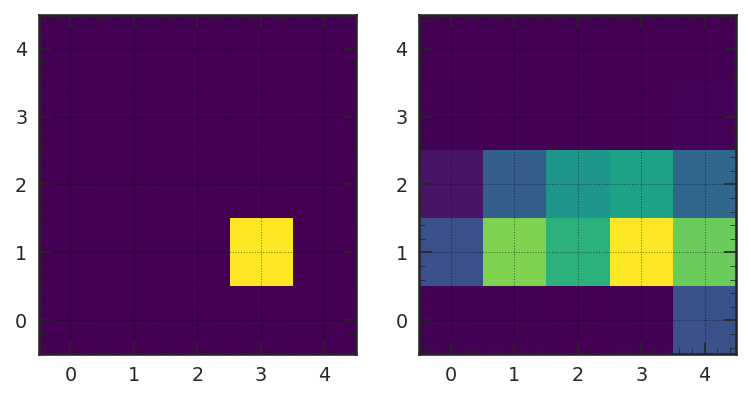

6


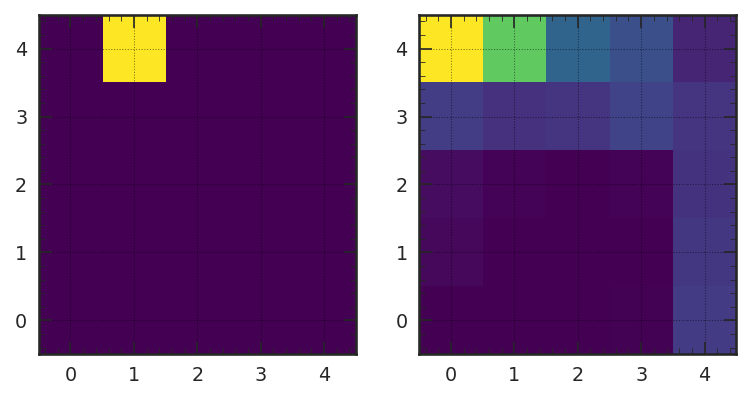

7


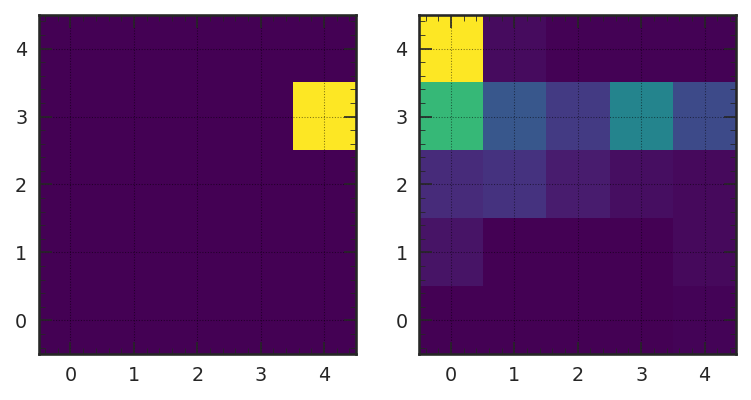

8


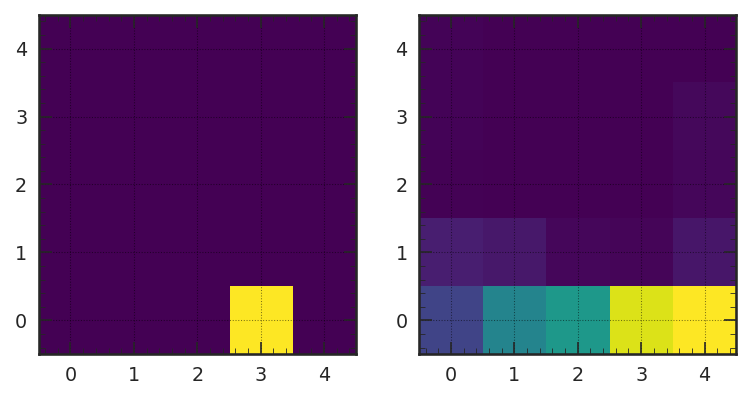

9


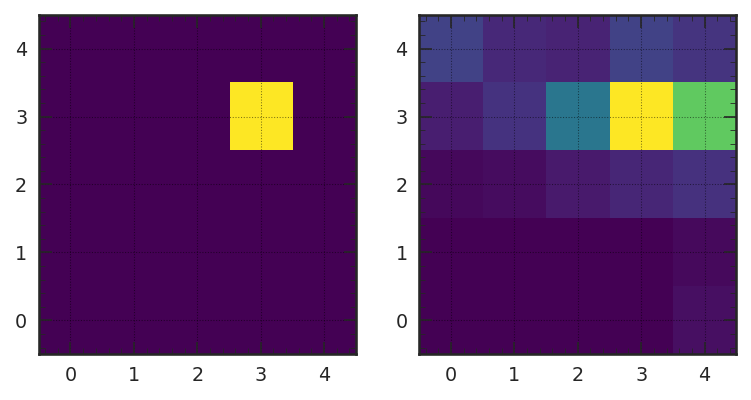

In [17]:
for ievt in range(10):
  print(ievt)
  fig, axs = plt.subplots(1, 2, figsize=(6,3))
  ax = axs[0]
  img = y_test[ievt].reshape(num_par_rows, num_par_cols)
  ax.imshow(img, origin='lower', interpolation='none', aspect='auto')
  ax = axs[1]
  img = y_test_pred[ievt].reshape(num_par_rows, num_par_cols)
  ax.imshow(img, origin='lower', interpolation='none', aspect='auto')
  plt.show()

21


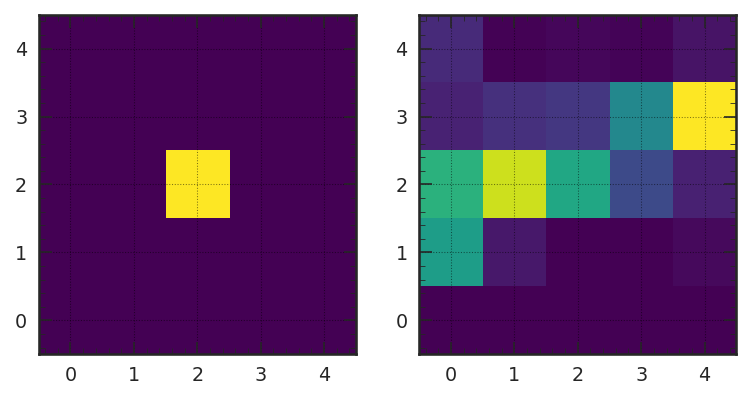

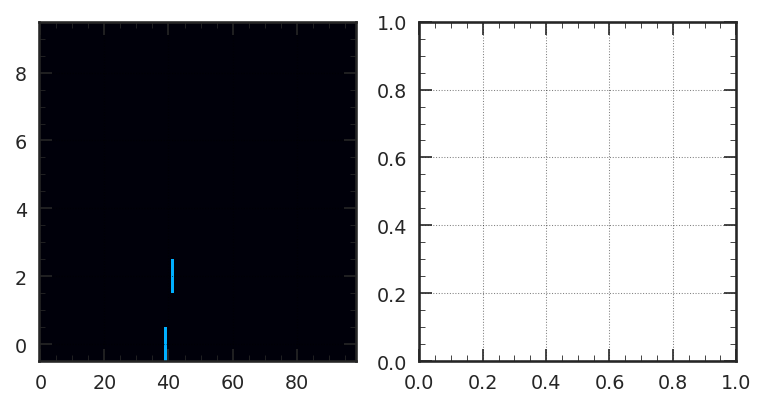

101


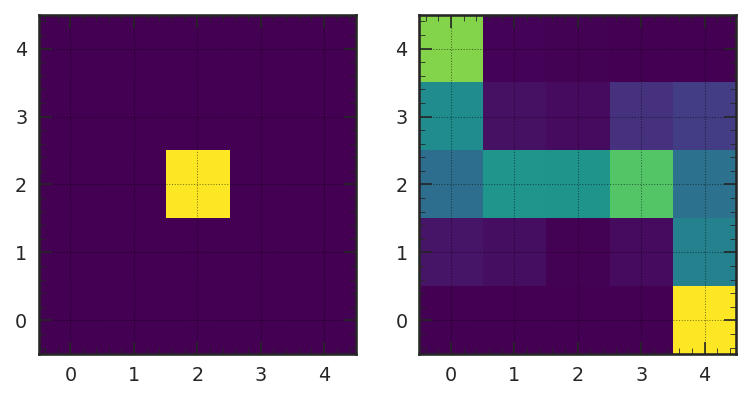

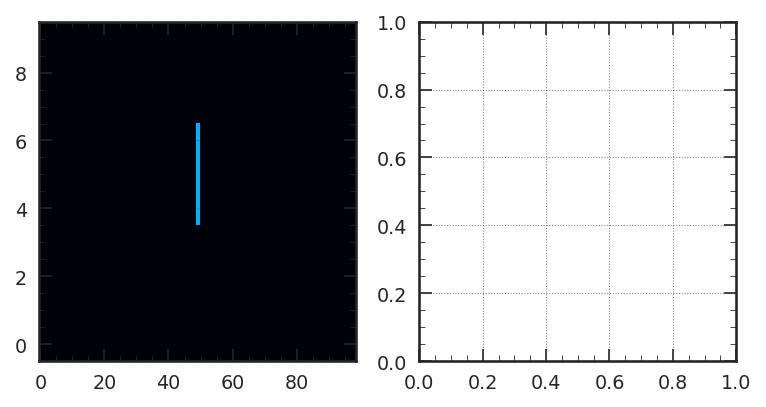

149


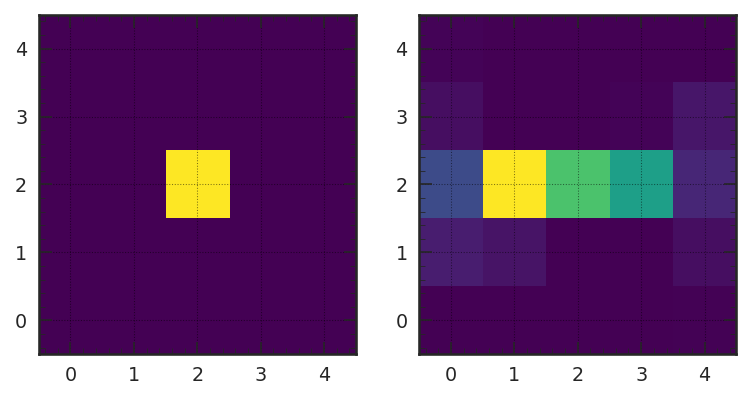

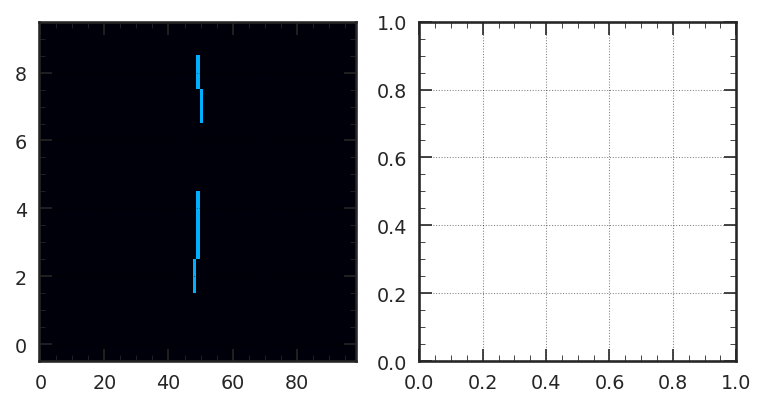

202


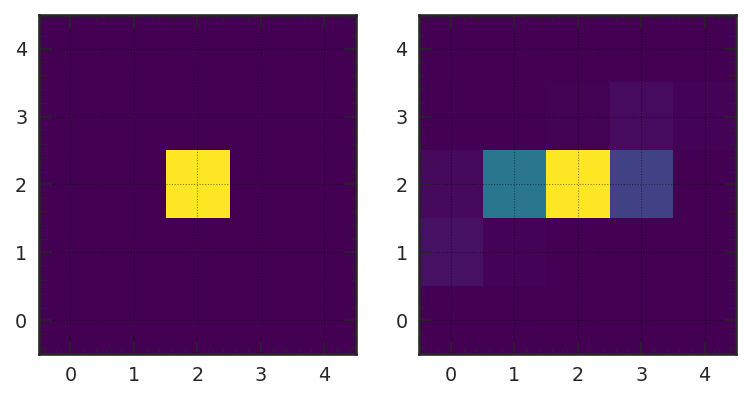

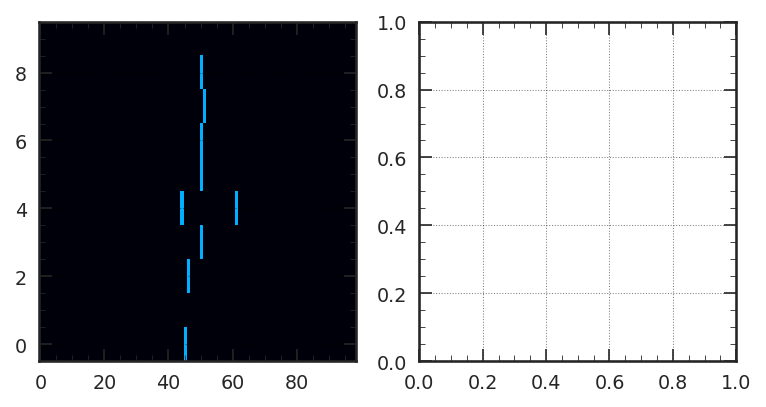

222


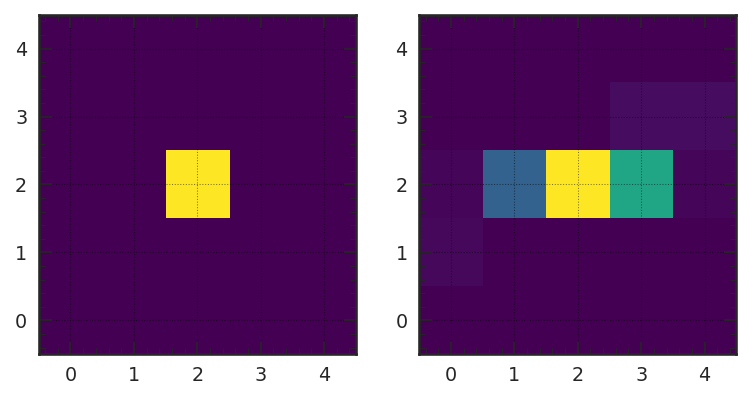

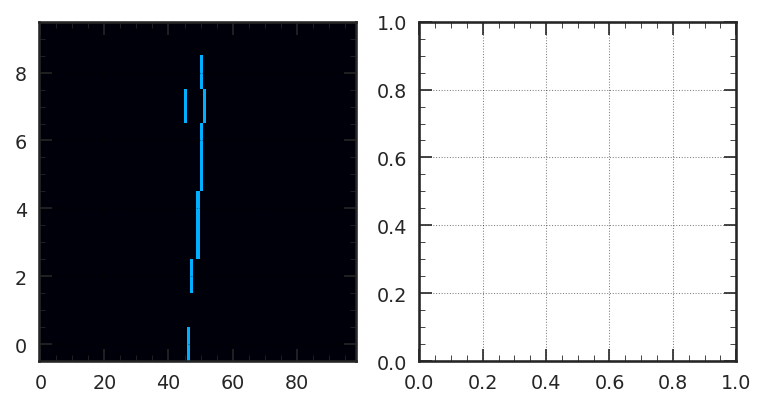

231


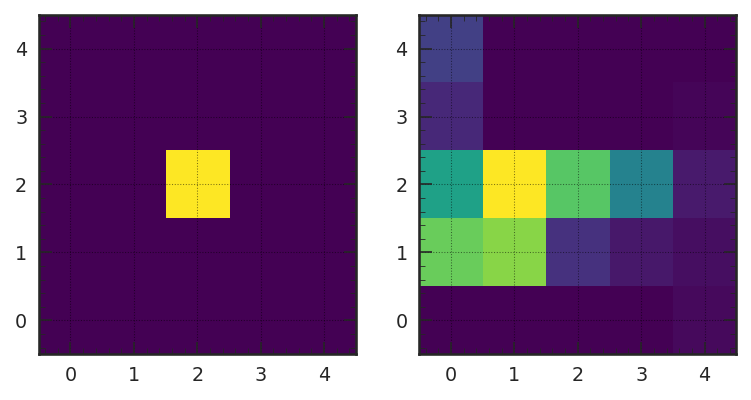

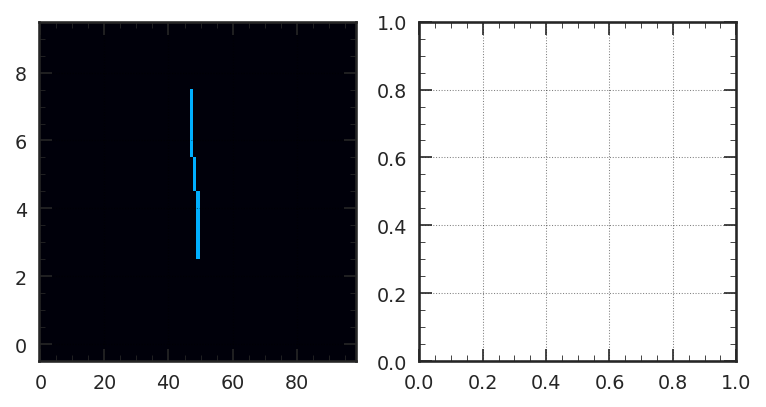

264


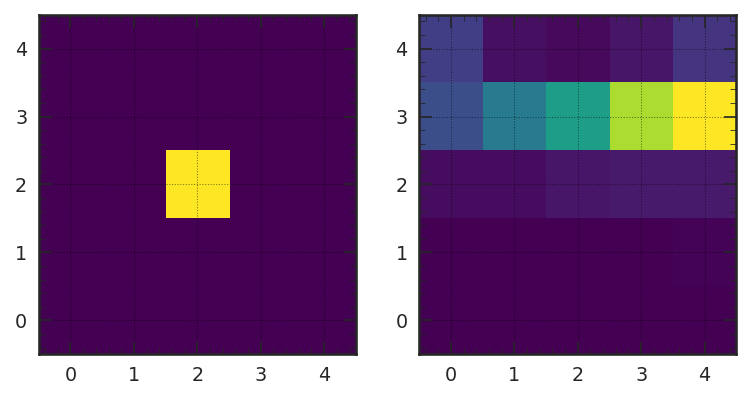

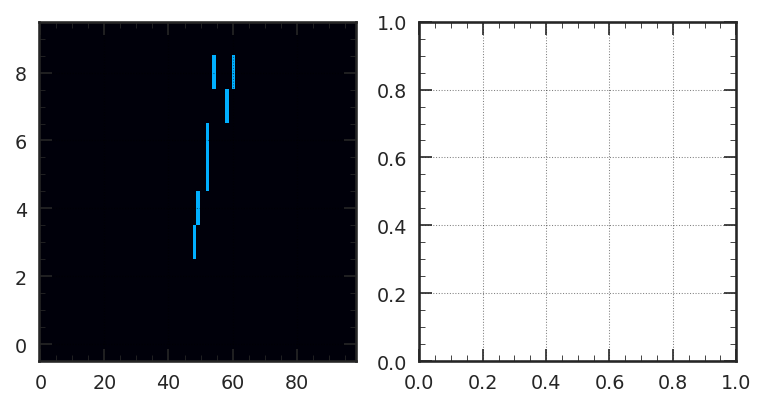

278


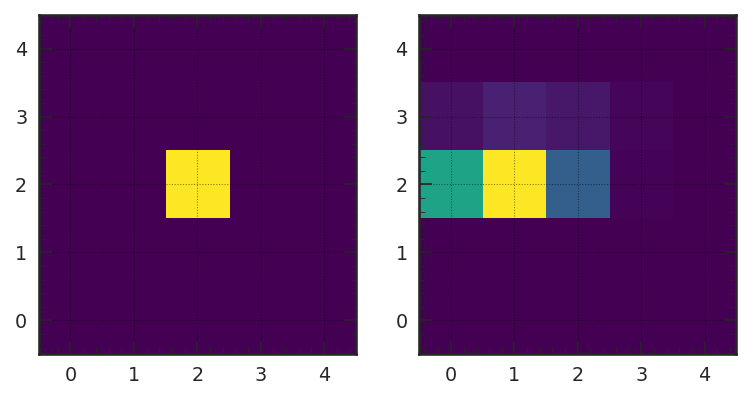

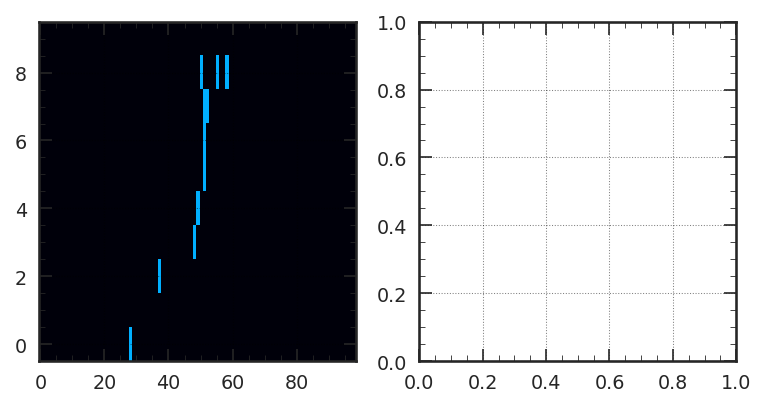

293


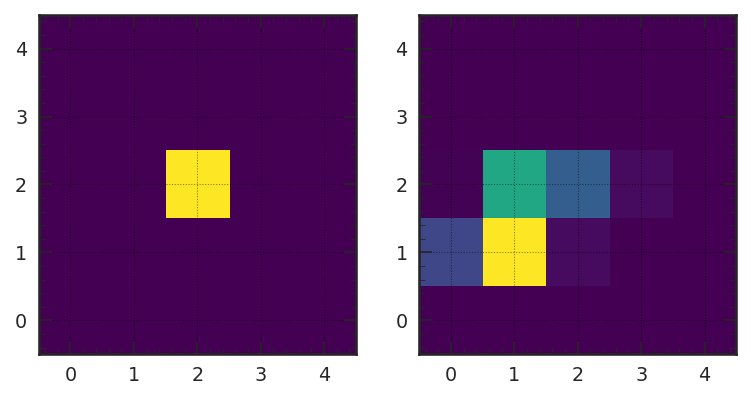

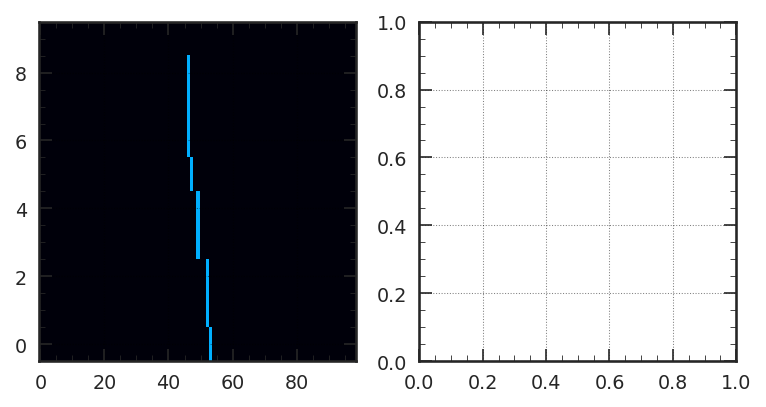

In [18]:
for ievt in range(300):
  if y_test[ievt][(2 * num_par_cols + 2)] == 0:
    continue

  print(ievt)
  fig, axs = plt.subplots(1, 2, figsize=(6,3))
  ax = axs[0]
  img = y_test[ievt].reshape(num_par_rows, num_par_cols)
  ax.imshow(img, origin='lower', interpolation='none', aspect='auto')
  ax = axs[1]
  img = y_test_pred[ievt].reshape(num_par_rows, num_par_cols)
  ax.imshow(img, origin='lower', interpolation='none', aspect='auto')
  plt.show()

  fig, axs = plt.subplots(1, 2, figsize=(6,3))
  ax = axs[0]
  ax.imshow(x_test[ievt][..., 0], origin='lower', interpolation='none', aspect='auto',
            cmap=blue_hot, vmin=0, vmax=1.6)
  #ax = axs[1]
  #ax.imshow(x_test[ievt][..., 0], origin='lower', interpolation='none', aspect='auto',
  #          cmap=blue_hot, vmin=0, vmax=1.6)
  plt.show()

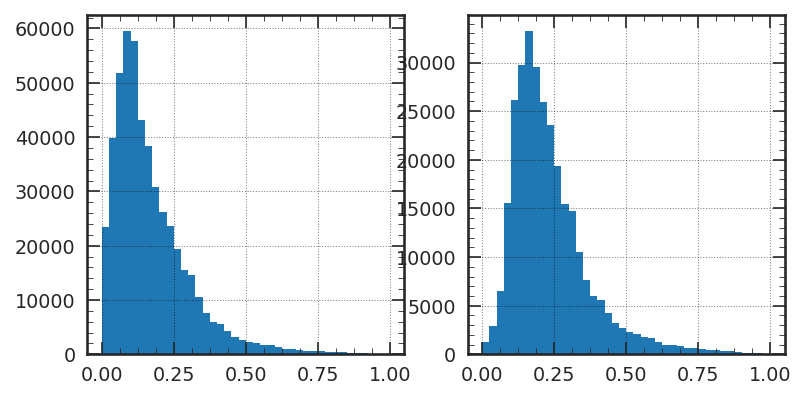

In [19]:
def find_top_k(arr, k=5):
  # Based on https://stackoverflow.com/q/6910641
  indices = np.argpartition(arr, -k)[-k:]
  return indices[np.argsort(arr[indices])][::-1]

activations_1 = []
activations_2 = []
for ievt in range(len(y_test)):
  for x in y_test_pred[ievt][find_top_k(y_test_pred[ievt])]:
    activations_1.append(x)
  for x in y_test_pred[ievt][find_top_k(y_test_pred[ievt], k=3)]:
    activations_2.append(x)

activations_1 = np.asarray(activations_1)
activations_2 = np.asarray(activations_2)

fig, axs = plt.subplots(1, 2, figsize=(6,3))
ax = axs[0]
ax.hist(activations_1, range=(0,1), bins=40)
ax = axs[1]
ax.hist(activations_2, range=(0,1), bins=40)
plt.show()

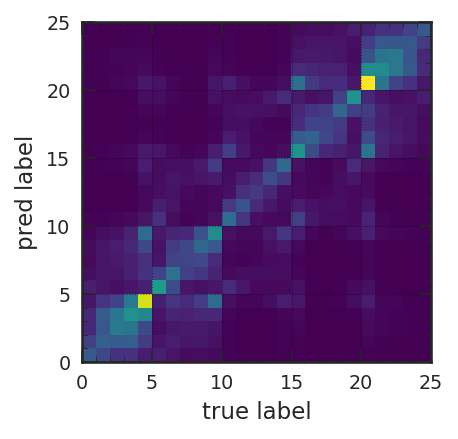

In [20]:
# Confusion matrix

single_val = lambda t: t[0]

h = np.zeros((num_classes, num_classes), dtype=np.float32)
for ievt in range(len(y_test)):
  lab = single_val(np.nonzero(y_test[ievt]))
  h[lab, :] += y_test_pred[ievt]

fig, ax = plt.subplots(1, 1, figsize=(3,3))
xedges = np.arange(num_classes+1)
yedges = np.arange(num_classes+1)
_ = hist2d_on_binned_array(h.T, xedges, yedges, ax=ax, colorbar=False)
ax.set_xlabel(r'true label')
ax.set_ylabel(r'pred label')
plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


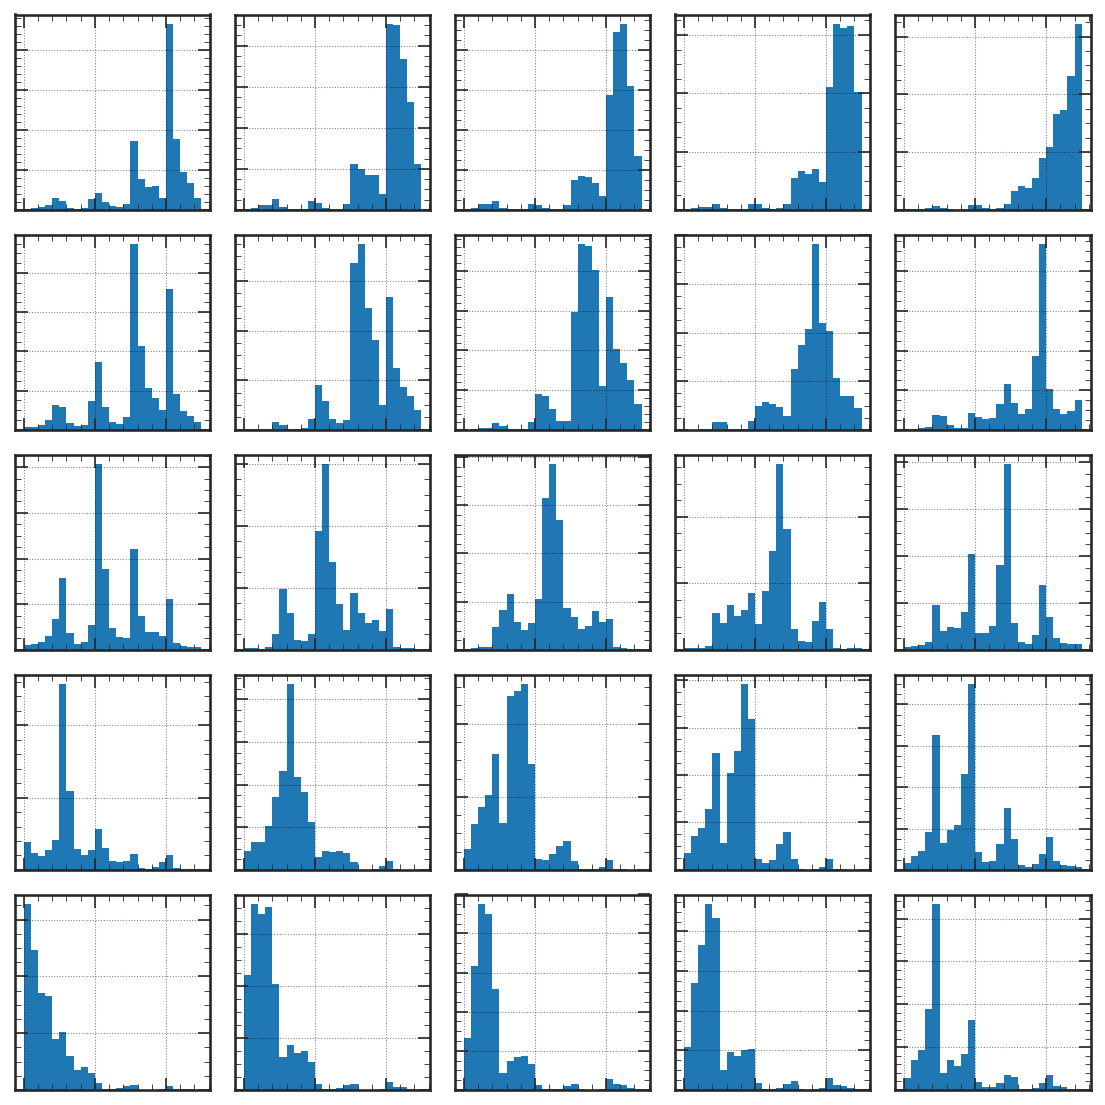

In [21]:
fig, axs = plt.subplots(num_par_rows, num_par_cols, figsize=(7.5,7.5), tight_layout=True)
for i in range(num_par_rows * num_par_cols):
  ax = axs[(num_par_rows-1) - i//5, i%5]   # axs[0,0] is top left
  _ = hist_on_binned_array(h[i], xedges, ax=ax)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
plt.show()

In [22]:
# Activation maps

x_test_dummy = np.zeros((num_box_rows * num_box_cols, num_box_rows, num_box_cols, num_box_channels), dtype=np.float32)

for ievt in range(len(x_test_dummy)):
  row, col = (ievt//num_box_cols), (ievt%num_box_cols)
  x_test_dummy[ievt][row, col] = 1

y_test_dummy = loaded_model.predict(x_test_dummy, batch_size=4096)

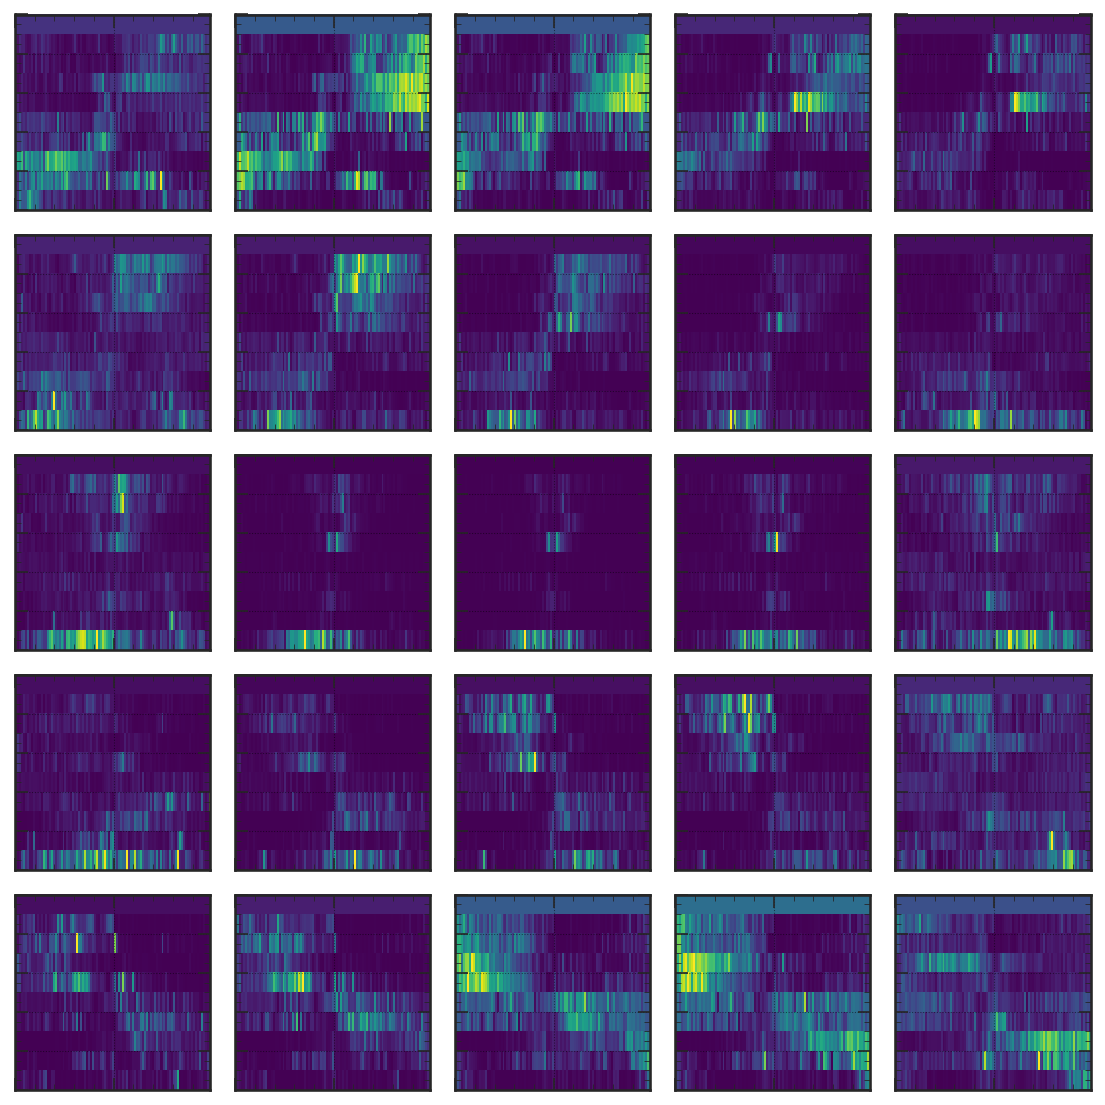

In [23]:
fig, axs = plt.subplots(num_par_rows, num_par_cols, figsize=(7.5,7.5), tight_layout=True)
for i in range(num_par_rows * num_par_cols):
  ax = axs[(num_par_rows-1) - i//5, i%5]   # axs[0,0] is top left
  xedges = np.arange(num_box_cols+1)
  yedges = np.arange(num_box_rows+1)
  h = y_test_dummy[..., i].reshape(num_box_rows, num_box_cols)
  #if (i//5) == 2 and (i%5) == 2:
  #  print(i, (i//5, i%5), h)
  _ = hist2d_on_binned_array(h.T, xedges, yedges, ax=ax, colorbar=False)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
plt.show()

In [24]:
h = y_test_dummy[..., (2 * num_par_cols + 2)].reshape(num_box_rows, num_box_cols)
print(h.shape, h.max(), np.nonzero(h > 0.01))

(10, 99) 0.08991009 (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       6, 7, 8]), array([26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 61, 63,
       64, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 54, 40]))


In [25]:
#FIXME: use binary CNN